INFO:__main__:Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
INFO:__main__:scikit-learn: 1.7.0
INFO:__main__:Dataset carregado com 525000 linhas e 20 colunas.
INFO:__main__:Treinando modelo RandomForest...
INFO:__main__:Avaliando modelo...


              precision    recall  f1-score   support

    contábil       0.92      0.92      0.92     26147
  financeiro       0.76      0.78      0.77     39474
      fiscal       0.46      0.46      0.46     13156
    jurídico       1.00      1.00      1.00     13101
  tributário       0.85      0.78      0.82     13122

    accuracy                           0.80    105000
   macro avg       0.80      0.79      0.79    105000
weighted avg       0.80      0.80      0.80    105000

Acurácia: 0.8034
F1-score macro: 0.7930


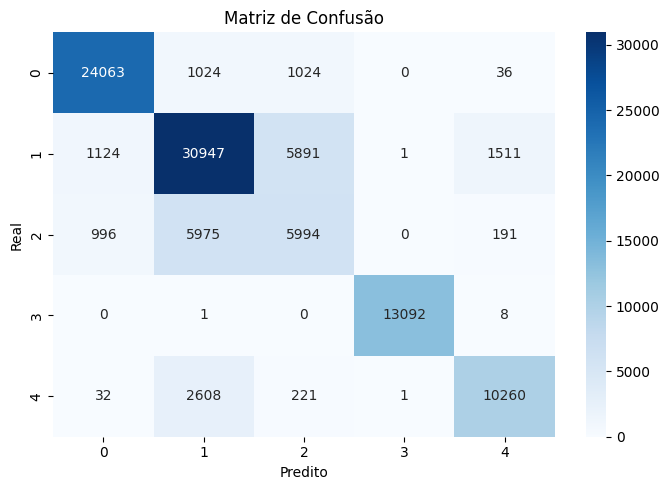

INFO:__main__:Executando validação cruzada 5-fold (f1_macro)...
INFO:__main__:Scores CV: [0.79054816 0.79061031 0.79377009 0.79247849 0.79131529]
INFO:__main__:Média CV: 0.7917 ± 0.0012


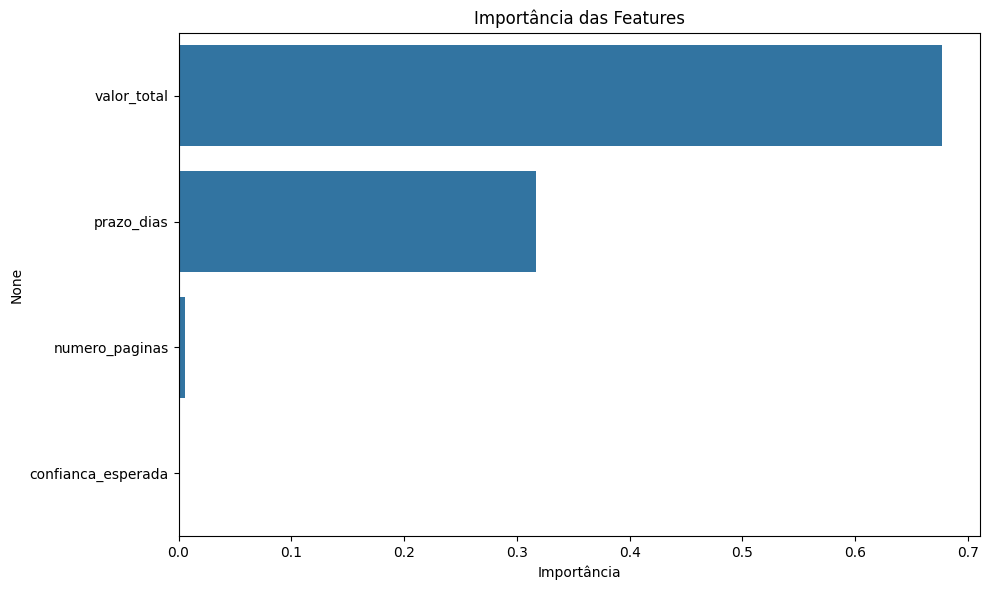

INFO:__main__:Modelo salvo em ../models/rf_pipeline.pkl


In [5]:
# --- Instalar dependências no ambiente do notebook
!pip install pandas matplotlib seaborn scikit-learn joblib --quiet

# --- Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib
import sys

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# --- Logging
logging.basicConfig(level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

logger.info(f"Python: {sys.version}")
logger.info(f"scikit-learn: {sys.modules['sklearn'].__version__}")

# --- 1. Carregar dados
DATA_PATH = "../data/processed/training_data.csv"
df = pd.read_csv(DATA_PATH)
logger.info(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

# --- 2. Datas e feature derivada
for col in ["data_emissao", "data_vencimento"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")
df["prazo_dias"] = (df["data_vencimento"] - df["data_emissao"]).dt.days

# --- 3. Definir target e colunas a remover
TARGET_COL = "classificacao"
drop_cols = [
    "id", "nome_emissor", "cnpj_emissor", "cpf_responsavel", "numero_documento",
    "raiz_cnpj", "filial_cnpj", "dv_cnpj", "descricao", "observacao",
    "data_emissao", "data_vencimento",
    "categoria", "status", "tipo_documento"  # ← ⚠️ possível vazamento
]

# --- 4. Remover classes raras
y_counts = df[TARGET_COL].value_counts()
valid_classes = y_counts[y_counts >= 5].index
df = df[df[TARGET_COL].isin(valid_classes)]

# --- 5. Separar X e y
X = df.drop(columns=[col for col in drop_cols if col in df.columns] + [TARGET_COL])
y = df[TARGET_COL]

# --- 6. Corrigir tipos e valores nulos
numerical_cols = ["valor_total", "numero_paginas", "confianca_esperada", "prazo_dias"]
for col in numerical_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce")
X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

# Fallback para garantir ausência de NaNs
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(0)

assert not X.isnull().any().any(), "Ainda há valores ausentes em X!"

# --- 7. Preprocessamento e pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_cols)
])

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# --- 8. Separar treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 9. Treinar modelo
logger.info("Treinando modelo RandomForest...")
pipeline.fit(X_train, y_train)

# --- 10. Avaliar
logger.info("Avaliando modelo...")
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-score macro: {f1_score(y_test, y_pred, average='macro'):.4f}")

# --- 11. Matriz de confusão
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# --- 12. Validação cruzada
logger.info("Executando validação cruzada 5-fold (f1_macro)...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
logger.info(f"Scores CV: {cv_scores}")
logger.info(f"Média CV: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# --- 13. Importância das features
feature_names = numerical_cols
importances = pipeline.named_steps["classifier"].feature_importances_
importances_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_df.values, y=importances_df.index)
plt.title("Importância das Features")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

# --- 14. Exportar modelo
MODEL_PATH = "../models/rf_pipeline.pkl"
joblib.dump(pipeline, MODEL_PATH)
logger.info(f"Modelo salvo em {MODEL_PATH}")
